<a href="https://colab.research.google.com/github/Anantk2908/Image_Segmentation_using_U-NET/blob/main/U_Net_Image_segmentation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Paper Review
U net is better than the sliding window method

CNN is used for classification tasks. So for image segmentation the image is cropped then each pixel is passed through another CNN.

Advantages of this method is that since the image is divided into patches the training data is much larger than the number of training images.

Although having advantages the disadvantages outweigh the advantages.
Firstly such a network can be quite slow because the model goes through each pixel and since it checks for neighbours of the pixel there are a lot of overlapping patches.

### Architecture of U-Net
![archi.png](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

It basically downscales the image to get to know what is the image and then upscales the image to know where in the image is the object located at.





## Creating the Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

## This is the Double Conv used in each step
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3,1,1, bias=False),  #KernelSize, Stride, Padding=1(Input and output size is same)
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3,1,1, bias=False),  #KernelSize, Stride, Padding=1(Input and output size is same)
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),  
    )
  def forward(self, x):
    return self.conv(x)

  
class UNET(nn.Module):
  def __init__(
      self, in_channels = 3, out_channels= 1, features=[64,128,256,512],
  ):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Downsampling part of the UNET
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    # Up part of the UNET
    # We will transpose convolutions for upsampling
    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(
              feature*2, feature, kernel_size=2, stride=2,
          )
      )
      self.ups.append(DoubleConv(feature*2, feature))


    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
  
  def forward(self,x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups),2):
        x = self.ups[idx](x)
        skip_connection = skip_connections[idx//2]

        if x.shape != skip_connection.shape:
          x = TF.resize(x, size=skip_connection.shape[2:])

        concat_skip = torch.cat((skip_connection,x),dim=1)
        x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

def test():
  x = torch.randn((3,1,161,161))  # Batch Size, 1 channel, Size
  model = UNET(in_channels=1, out_channels=1)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape

if __name__ == "__main__":
  test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


# Getting the data

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!kaggle datasets download -d anant2k/car-segmentation-unet

 99% 433M/438M [00:18<00:00, 25.5MB/s]
100% 438M/438M [00:18<00:00, 24.4MB/s]


In [ ]:
!unzip /content/car-segmentation-unet.zip

## Cleaning and segmenting the data

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CarvanaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

## Utils

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = CarvanaDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = CarvanaDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()

In [ ]:
!mkdir /content/saved_images

## Training the data

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 50
NUM_WORKERS = 2
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "/content/train/"
TRAIN_MASK_DIR = "/content/train_masks/"
VAL_IMG_DIR = "/content/val_images/"
VAL_MASK_DIR = "/content/val_masks/"

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


train_transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = get_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms,
    NUM_WORKERS,
    PIN_MEMORY,
)

if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

check_accuracy(val_loader, model, device=DEVICE)



scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

    # print some examples to a folder
    save_predictions_as_imgs(
        val_loader, model, folder="/content/saved_images/", device=DEVICE
    )

Got 2353063/3072000 with acc 76.60
Dice score: 0.0


100%|██████████| 313/313 [03:37<00:00,  1.44it/s, loss=0.106]


=> Saving checkpoint
Got 3037450/3072000 with acc 98.88
Dice score: 0.9759843945503235


100%|██████████| 313/313 [03:34<00:00,  1.46it/s, loss=0.0611]


=> Saving checkpoint
Got 3043804/3072000 with acc 99.08
Dice score: 0.9803979992866516


 50%|█████     | 158/313 [01:48<01:34,  1.63it/s, loss=0.048]

In [ ]:
!wget https://carwow-uk-wp-3.imgix.net/Volvo-XC40-white-scaled.jpg 

--2022-10-03 13:33:51--  https://carwow-uk-wp-3.imgix.net/Volvo-XC40-white-scaled.jpg
Resolving carwow-uk-wp-3.imgix.net (carwow-uk-wp-3.imgix.net)... 199.232.46.208, 2a04:4e42:48::720
Connecting to carwow-uk-wp-3.imgix.net (carwow-uk-wp-3.imgix.net)|199.232.46.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 392650 (383K) [image/jpeg]
Saving to: ‘Volvo-XC40-white-scaled.jpg’

Volvo-XC40-white-sc 100%[===================>] 383.45K  --.-KB/s    in 0.006s  

2022-10-03 13:33:51 (57.9 MB/s) - ‘Volvo-XC40-white-scaled.jpg’ saved [392650/392650]



In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/0/01/Hyundai_Sonata_2.0_Turbo_LF_FL_black_diplomatic_%283%29_%28cropped%29.jpg

--2022-10-02 16:52:44--  https://upload.wikimedia.org/wikipedia/commons/0/01/Hyundai_Sonata_2.0_Turbo_LF_FL_black_diplomatic_%283%29_%28cropped%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839446 (820K) [image/jpeg]
Saving to: ‘Hyundai_Sonata_2.0_Turbo_LF_FL_black_diplomatic_(3)_(cropped).jpg’

Hyundai_Sonata_2.0_ 100%[===================>] 819.77K  --.-KB/s    in 0.03s   

2022-10-02 16:52:44 (29.2 MB/s) - ‘Hyundai_Sonata_2.0_Turbo_LF_FL_black_diplomatic_(3)_(cropped).jpg’ saved [839446/839446]



In [ ]:
!wget https://www.collinsdictionary.com/images/full/sportscar_13620490_1000.jpg

--2022-10-03 13:33:51--  https://www.collinsdictionary.com/images/full/sportscar_13620490_1000.jpg
Resolving www.collinsdictionary.com (www.collinsdictionary.com)... 172.67.19.203, 104.20.190.42, 104.20.191.42, ...
Connecting to www.collinsdictionary.com (www.collinsdictionary.com)|172.67.19.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39800 (39K) [image/jpeg]
Saving to: ‘sportscar_13620490_1000.jpg’

sportscar_13620490_ 100%[===================>]  38.87K  --.-KB/s    in 0s      

2022-10-03 13:33:52 (147 MB/s) - ‘sportscar_13620490_1000.jpg’ saved [39800/39800]



In [ ]:
#download an image from google and forward pass though model
import matplotlib.pyplot as plt

image_np= np.array(Image.open("/content/Volvo-XC40-white-scaled.jpg").convert("RGB"))
print(image_np.shape)

test_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

tensor_img = test_transforms(image=image_np)["image"]
tensor_img_batch = tensor_img.unsqueeze(0)
print("raw image size", tensor_img.shape)
print("batch element size", tensor_img_batch.shape)
model=model.eval()

with torch.no_grad():
  seg_map = model(tensor_img_batch.to(DEVICE))
  print(seg_map.shape)

(1280, 2560, 3)
raw image size torch.Size([3, 160, 240])
batch element size torch.Size([1, 3, 160, 240])
torch.Size([1, 1, 160, 240])


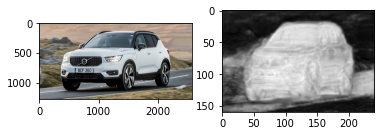

In [ ]:
f, axarr = plt.subplots(1, 2)
axarr[1].imshow(seg_map.cpu()[0][0], cmap='gray')
axarr[0].imshow(image_np)

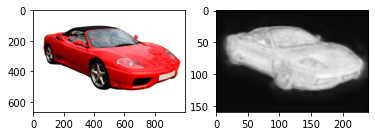

In [ ]:
f, axarr = plt.subplots(1, 2)
axarr[1].imshow(seg_map.cpu()[0][0], cmap='gray')
axarr[0].imshow(image_np)

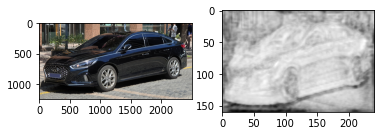

In [ ]:
f, axarr = plt.subplots(1, 2)
axarr[1].imshow(seg_map.cpu()[0][0], cmap='gray')
axarr[0].imshow(image_np)

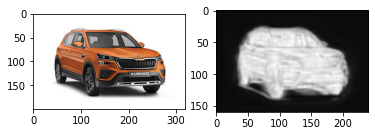

In [ ]:
f, axarr = plt.subplots(1, 2)
axarr[1].imshow(seg_map.cpu()[0][0], cmap='gray')
axarr[0].imshow(image_np)

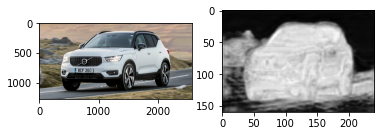

In [ ]:
f, axarr = plt.subplots(1, 2)
axarr[1].imshow(seg_map.cpu()[0][0], cmap='gray')
axarr[0].imshow(image_np)

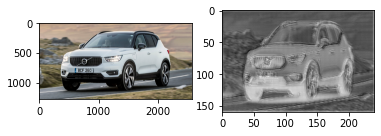

In [ ]:
f, axarr = plt.subplots(1, 2)
axarr[1].imshow(seg_map.cpu()[0][0], cmap='gray')
axarr[0].imshow(image_np)


In [ ]:
!zip -r output.zip /content/saved_images

In [ ]:
from google.colab import files
files.download('/content/output.zip') 

In [ ]:
!ls -sh /content

In [ ]:
from google.colab import files
files.download('/content/my_checkpoint.pth.tar') 